<a href="https://colab.research.google.com/github/Ashish110520/FinSecure_1/blob/main/ml_lab(16th_sep).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving loan_data.csv to loan_data.csv


In [2]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

# ---------------------------------------------------------
# 1. Load Data
# ---------------------------------------------------------
# Assuming the file is uploaded to Colab as 'loan_data.csv'
df = pd.read_csv('loan_data.csv')

# Drop ID as it's not a predictive feature
df = df.drop(columns=['id'])

# Separate Features and Target
X = df.drop(columns=['loan_paid_back'])
y = df['loan_paid_back']

# ---------------------------------------------------------
# 2. Feature Engineering & Preprocessing Pipeline
# ---------------------------------------------------------

# Define feature groups
numeric_features = [
    'annual_income', 'debt_to_income_ratio', 'credit_score',
    'loan_amount', 'interest_rate'
]

categorical_features = [
    'gender', 'marital_status', 'education_level',
    'employment_status', 'loan_purpose', 'grade_subgrade'
]

# Create Transformers
# 1. Numeric: Standard scaling to normalize range
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# 2. Categorical: One-Hot Encoding to handle categories
# handle_unknown='ignore' ensures the model doesn't crash if it sees a new category in production
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# ---------------------------------------------------------
# 3. Model Development and Tuning
# ---------------------------------------------------------

# Split data: 80% Training, 20% Testing
# We use a random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the full model pipeline (Preprocessing + Classifier)
# We use RandomForest as it handles non-linear patterns well, as requested by leadership.
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1))
])

# Train the model
print("Training the model...")
model.fit(X_train, y_train)

# Predict probabilities on the Test set
# We take the probability of class 1 (Paid Back)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate Overall AUC
overall_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\n--- Model Performance ---")
print(f"Overall ROC AUC Score: {overall_auc:.4f}")

# ---------------------------------------------------------
# 4. Subgroup Analysis (Fairness & Performance Check)
# ---------------------------------------------------------

# Create a DataFrame for analysis containing actuals, preds, and original categorical features
analysis_df = X_test.copy()
analysis_df['actual'] = y_test
analysis_df['predicted_prob'] = y_pred_proba

print("\n--- Subgroup Analysis: Education Level ---")
edu_results = []
for level in analysis_df['education_level'].unique():
    subset = analysis_df[analysis_df['education_level'] == level]
    if len(subset) > 0 and subset['actual'].nunique() > 1:
        auc = roc_auc_score(subset['actual'], subset['predicted_prob'])
        edu_results.append({'Education Level': level, 'AUC': auc, 'Count': len(subset)})
    else:
        edu_results.append({'Education Level': level, 'AUC': 'N/A (Not enough data)', 'Count': len(subset)})

# Convert to DataFrame for display
edu_df = pd.DataFrame(edu_results).sort_values(by='AUC', ascending=False)
print(edu_df)

print("\n--- Subgroup Analysis: Loan Purpose ---")
purpose_results = []
for purpose in analysis_df['loan_purpose'].unique():
    subset = analysis_df[analysis_df['loan_purpose'] == purpose]
    # Calculate AUC only if there are samples and both classes exist in the subset
    if len(subset) > 0 and subset['actual'].nunique() > 1:
        auc = roc_auc_score(subset['actual'], subset['predicted_prob'])
        purpose_results.append({'Loan Purpose': purpose, 'AUC': auc, 'Count': len(subset)})

purpose_df = pd.DataFrame(purpose_results).sort_values(by='AUC', ascending=False)

# Display Top 3 and Bottom 3
print("\nTop 3 Loan Purposes by AUC:")
print(purpose_df.head(3))

print("\nBottom 3 Loan Purposes by AUC:")
print(purpose_df.tail(3))


Training the model...

--- Model Performance ---
Overall ROC AUC Score: 0.9068

--- Subgroup Analysis: Education Level ---
  Education Level       AUC  Count
2           Other  0.912140   2439
3     High School  0.908566  16540
1      Bachelor's  0.906480  25130
4             PhD  0.903433   1031
0        Master's  0.902905   8483

--- Subgroup Analysis: Loan Purpose ---

Top 3 Loan Purposes by AUC:
         Loan Purpose       AUC  Count
0            Vacation  0.922689    752
2  Debt consolidation  0.909153  29281
6                Home  0.907285   4056

Bottom 3 Loan Purposes by AUC:
  Loan Purpose       AUC  Count
5      Medical  0.904625   2004
1        Other  0.902078   5703
3     Business  0.891752   3117


Dataset Shape: (268114, 12)
Class Distribution (Target Variable):
 loan_paid_back
1    0.798422
0    0.201578
Name: proportion, dtype: float64

Training the model...
Model training complete.

Global Model AUC on Test Set: 0.9049

--- Subgroup Analysis: Education Level (AUC) ---
education_level
Bachelor's     0.907053
High School    0.901792
Master's       0.902223
Other          0.913977
PhD            0.896162
dtype: float64

--- Subgroup Analysis: Loan Purpose (AUC) ---

Top 3 Performing Purposes:
loan_purpose
Vacation     0.919802
Medical      0.914298
Education    0.912317
dtype: float64

Bottom 3 Performing Purposes:
loan_purpose
Debt consolidation    0.903791
Business              0.902707
Car                   0.898965
dtype: float64


/tmp/ipython-input-678850530.py:116: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  education_auc = analysis_df.groupby('education_level').apply(get_auc)
/tmp/ipython-input-678850530.py:121: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  purpose_auc = analysis_df.groupby('loan_purpose').apply(get_auc).sort_values(ascending=False)


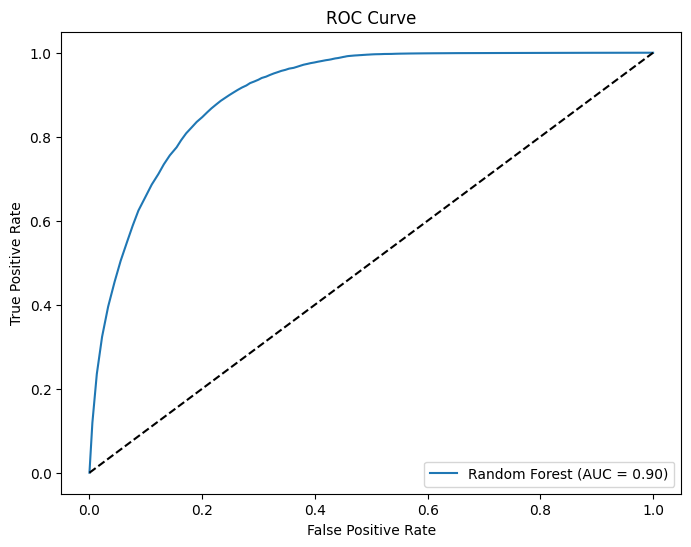

In [3]:
# ==========================================
# IMPORTS & SETUP
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report

# ==========================================
# SECTION 1: LOAD DATA & TARGET ANALYSIS
# ==========================================
# Load the dataset (Assuming file is already uploaded as 'loan_data.csv')
df = pd.read_csv('loan_data.csv')

# Drop the 'id' column as it is not a feature
df = df.drop('id', axis=1)

print("Dataset Shape:", df.shape)
print("Class Distribution (Target Variable):\n", df['loan_paid_back'].value_counts(normalize=True))

# Define Features (X) and Target (y)
X = df.drop('loan_paid_back', axis=1)
y = df['loan_paid_back']

# Split Data: 80% Training, 20% Testing
# Stratify ensures the default rate is consistent between train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ==========================================
# SECTION 2: FEATURE ENGINEERING & PIPELINE
# ==========================================

# 1. Define Column Groups
numeric_features = ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']
categorical_features = ['gender', 'marital_status', 'employment_status', 'loan_purpose', 'grade_subgrade']
ordinal_features = ['education_level']

# 2. Define Custom Order for Education
education_order = [['Other', 'High School', "Bachelor's", "Master's", 'PhD']]

# 3. Create Preprocessing Pipelines
# Numeric: Handle missing values with median -> Scale data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical: Handle missing with mode -> One Hot Encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Ordinal: Handle missing with mode -> Ordinal Encode
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=education_order, handle_unknown='use_encoded_value', unknown_value=-1))
])

# 4. Combine into a Single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features)
    ])

# ==========================================
# SECTION 3: MODEL DEVELOPMENT (Random Forest)
# ==========================================

# Create the full pipeline: Preprocessor -> Classifier
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])

# Train the model
print("\nTraining the model...")
model.fit(X_train, y_train)
print("Model training complete.")

# Predict probabilities for the test set (needed for AUC)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate Global AUC
global_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nGlobal Model AUC on Test Set: {global_auc:.4f}")

# ==========================================
# SECTION 4: SUBGROUP ANALYSIS
# ==========================================

# Create a dataframe for analysis containing Test features, Actuals, and Predictions
analysis_df = X_test.copy()
analysis_df['actual'] = y_test
analysis_df['predicted_proba'] = y_pred_proba

# Helper function to calculate AUC safely
def get_auc(df):
    if len(df['actual'].unique()) > 1:
        return roc_auc_score(df['actual'], df['predicted_proba'])
    else:
        return np.nan

# 1. Analysis by Education Level
print("\n--- Subgroup Analysis: Education Level (AUC) ---")
education_auc = analysis_df.groupby('education_level').apply(get_auc)
print(education_auc)

# 2. Analysis by Loan Purpose
print("\n--- Subgroup Analysis: Loan Purpose (AUC) ---")
purpose_auc = analysis_df.groupby('loan_purpose').apply(get_auc).sort_values(ascending=False)

print("\nTop 3 Performing Purposes:")
print(purpose_auc.head(3))

print("\nBottom 3 Performing Purposes:")
print(purpose_auc.tail(3))

# Optional: Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {global_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()